In [2]:
import sys
import os

# Adiciona o diretório src ao sys.path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

# Importa os módulos
from data_fetching import fetch_inmet_data

In [3]:
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm
import folium
from folium.plugins import HeatMap
import pandas as pd

# Mapas segmentados

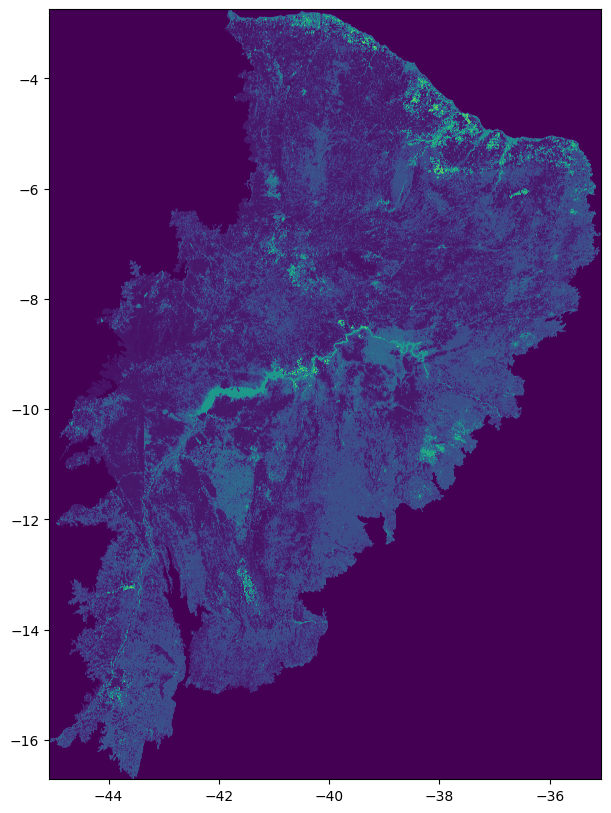

<Axes: >

In [4]:
# Caminho para o shapefile dos biomas
biomes_shp = '../dados/Biomas_250mil/lm_bioma_250.shp'

# Carregar o shapefile dos biomas
biomes = gpd.read_file(biomes_shp)

# Filtrar para obter apenas a Caatinga
caatinga = biomes[biomes['Bioma'] == 'Caatinga']

# Caminho para o arquivo GeoTiff
raster_path = '../dados/brasil_coverage_2022.tif'

# Carregar o arquivo GeoTiff e aplicar a máscara da Caatinga
with rasterio.open(raster_path) as src:
    out_image, out_transform = mask(src, caatinga.geometry, crop=True, nodata=0)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform,
                     "nodata": 0})

# Plotar a imagem recortada
plt.figure(figsize=(10, 10))
show(out_image, transform=out_transform, cmap='viridis')

In [5]:
# Salvar o resultado em um novo GeoTiff
out_tiff = '../dados/caatinga_extracted.tif'
with rasterio.open(out_tiff, "w", **out_meta) as dest:
    dest.write(out_image)

# Verificar as classificações presentes no raster extraído
unique_classes = np.unique(out_image)
print(unique_classes)

[ 0  3  4  5  9 11 12 15 20 21 23 24 25 29 30 31 32 33 39 41 46 48 49 50
 62]


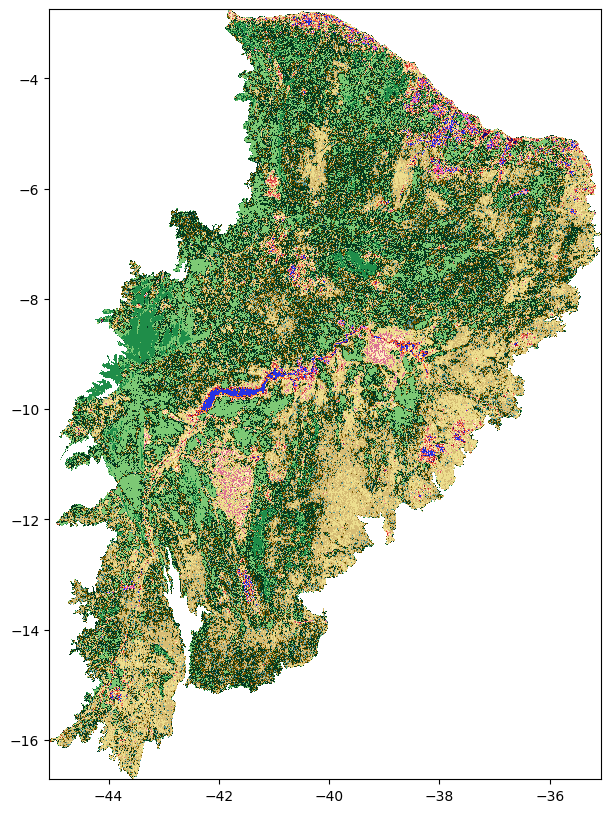

<Axes: >

In [6]:
# Dicionário de mapeamento de IDs de classes para cores
class_colors = {
    3: "#1f8d49", 4: "#7dc975", 5: "#04381d", 49: "#02d659", 20: "#db7093",
    11: "#519799", 12: "#d6bc74", 32: "#fc8114", 29: "#ffaa5f", 50: "#ad5100",
    15: "#edde8e", 39: "#f5b3c8", 62: "#ff69b4", 41: "#f54ca9", 46: "#d68fe2",
    48: "#e6ccff", 9: "#7a5900", 21: "#ffefc3", 23: "#ffa07a", 24: "#d4271e", 
    30: "#9c0027", 25: "#db4d4f", 33: "#2532e4",31: "#091077", 0: "#FFFFFF"
}

# Criar uma lista de cores para o colormap na ordem dos valores únicos
colors = [class_colors[key] for key in unique_classes]

# Criar o colormap e o normalizador
cmap = ListedColormap(colors)
norm = BoundaryNorm(boundaries=unique_classes, ncolors=len(unique_classes))

# Plotar o raster com as cores das classes
plt.figure(figsize=(10, 10))
show(out_image, transform=out_transform, cmap=cmap, norm=norm)

In [7]:
import basedosdados as bd

# Para carregar o dado direto no pandas
df_estacoes = bd.read_table(dataset_id='br_inmet_bdmep',
table_id='estacao',
billing_project_id="projetopdi-430718")

Downloading: 100%|██████████| 612/612 [00:00<00:00, 1126.09rows/s]


In [8]:
df_estacoes.head()

id_municipio id_estacao             estacao data_fundacao   latitude  \
0      5300108       A001            Brasilia    2000-05-07 -15.789444   
1      5300108       A042          Brazlandia    2017-07-19 -15.599722   
2      5300108       A045     Aguas Emendadas    2008-10-03 -15.596491   
3      5300108       A046   Gama (Ponte Alta)    2014-10-01 -15.935278   
4      5300108       A047  Paranoa (Coopa-Df)    2017-02-07 -16.012222   

   longitude  altitude  
0 -47.925833   1160.96  
1 -48.131111   1143.00  
2 -47.625801   1030.36  
3 -48.137500    990.00  
4 -47.557417   1043.00

In [9]:
# Convertendo o DataFrame em GeoDataFrame
gdf_estacoes = gpd.GeoDataFrame(
    df_estacoes, 
    geometry=gpd.points_from_xy(df_estacoes['longitude'], df_estacoes['latitude']),
    crs="EPSG:4674"
)

# Reprojetar o GeoDataFrame das estações para o mesmo CRS que o shapefile dos biomas
gdf_estacoes = gdf_estacoes.to_crs(caatinga.crs)

# Filtrar as estações que estão dentro da Caatinga
stations_within_caatinga = gdf_estacoes[gdf_estacoes.geometry.within(caatinga.unary_union)]

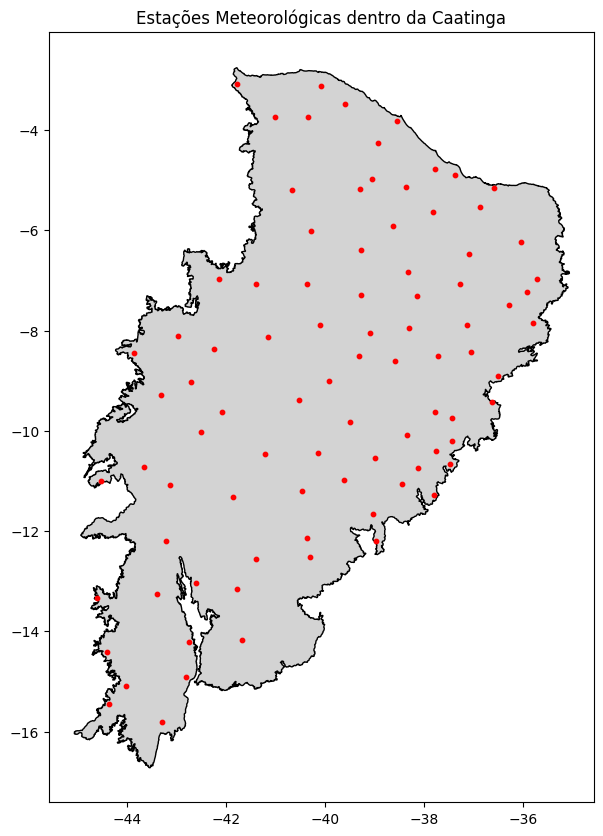

In [10]:
# Plotar um mapa com as estações
fig, ax = plt.subplots(figsize=(10, 10))
caatinga.plot(ax=ax, color='lightgrey', edgecolor='black')
stations_within_caatinga.plot(ax=ax, color='red', markersize=10)
plt.title('Estações Meteorológicas dentro da Caatinga')
plt.show()

In [11]:
# Recuperando os dados das estações dentro da Caatinga no ano de 2023
df_meta_dados = fetch_inmet_data([2023])

Downloading: 100%|██████████| 733824/733824 [03:14<00:00, 3768.61rows/s]


In [12]:
# Salvando o DataFrame em um arquivo CSV
df_meta_dados.to_csv('../dados/meta_dados_estacoes_2023.csv', index=False)
df_meta_dados.head()

ano  mes        data      hora id_estacao  precipitacao_total  \
0  2023    4  2023-04-09  06:00:00       A419                 NaN   
1  2023    4  2023-04-09  05:00:00       A313                 0.0   
2  2023   12  2023-12-21  20:00:00       A450                 0.0   
3  2023    4  2023-04-10  06:00:00       A313                 0.0   
4  2023   12  2023-12-22  01:00:00       A373                 0.0   

   pressao_atm_hora  pressao_atm_max  pressao_atm_min  radiacao_global  ...  \
0             971.4            971.6            971.4              NaN  ...   
1             950.6            950.8            950.4              NaN  ...   
2             983.2            983.3            982.9            146.1  ...   
3             951.6            951.7            951.2              NaN  ...   
4             980.2            980.2            980.1              NaN  ...   

   temperatura_max  temperatura_min  temperatura_orvalho_max  \
0             22.3             22.0                     22.2   
1             23.1             22.8                     22.8   
2             24.1             23.9                     24.1   
3             21.7             21.3                     21.6   
4             24.4             24.1                     24.0   

   temperatura_orvalho_min  umidade_rel_max  umidade_rel_min  \
0                     21.9             99.0             99.0   
1                     22.5             99.0             98.0   
2                     23.7            100.0             99.0   
3                     21.1             99.0             99.0   
4                     23.4             99.0             95.0   

   umidade_rel_hora  vento_direcao  vento_rajada_max  vento_velocidade  
0              99.0          221.0               NaN               NaN  
1              99.0          149.0               3.7               2.0  
2              99.0          123.0               5.7               2.9  
3              99.0          155.0               3.2               0.0  
4              99.0           18.0               1.6               0.6  

[5 rows x 22 columns]

In [13]:
df_meta_dados = pd.read_csv('../dados/meta_dados_estacoes_2023.csv')

# Adicionar lat e long de df_estacoes em df_meta_dados
df_meta_dados = df_meta_dados.merge(
    df_estacoes[['id_estacao', 'latitude', 'longitude']],
    how='left', 
    left_on='id_estacao', 
    right_on='id_estacao'
)

# Transformar 'data' pro tipo datetime
df_meta_dados['data'] = pd.to_datetime(df_meta_dados['data'])
df_meta_dados.head()

ano  mes       data      hora id_estacao  precipitacao_total  \
0  2023    4 2023-04-09  06:00:00       A419                 NaN   
1  2023    4 2023-04-09  05:00:00       A313                 0.0   
2  2023   12 2023-12-21  20:00:00       A450                 0.0   
3  2023    4 2023-04-10  06:00:00       A313                 0.0   
4  2023   12 2023-12-22  01:00:00       A373                 0.0   

   pressao_atm_hora  pressao_atm_max  pressao_atm_min  radiacao_global  ...  \
0             971.4            971.6            971.4              NaN  ...   
1             950.6            950.8            950.4              NaN  ...   
2             983.2            983.3            982.9            146.1  ...   
3             951.6            951.7            951.2              NaN  ...   
4             980.2            980.2            980.1              NaN  ...   

   temperatura_orvalho_max  temperatura_orvalho_min  umidade_rel_max  \
0                     22.2                     21.9             99.0   
1                     22.8                     22.5             99.0   
2                     24.1                     23.7            100.0   
3                     21.6                     21.1             99.0   
4                     24.0                     23.4             99.0   

   umidade_rel_min  umidade_rel_hora  vento_direcao  vento_rajada_max  \
0             99.0              99.0          221.0               NaN   
1             98.0              99.0          149.0               3.7   
2             99.0              99.0          123.0               5.7   
3             99.0              99.0          155.0               3.2   
4             95.0              99.0           18.0               1.6   

   vento_velocidade   latitude  longitude  
0               NaN -10.738056 -38.108333  
1               2.0  -7.225574 -35.904831  
2               2.9 -10.080833 -38.345833  
3               0.0  -7.225574 -35.904831  
4               0.6  -7.318333 -38.140833  

[5 rows x 24 columns]

In [14]:
# Reprojetar o GeoDataFrame das estações para o mesmo CRS que o shapefile dos biomas
gdf_estacoes = gdf_estacoes.to_crs(caatinga.crs)

# Filtrar as estações que estão dentro da Caatinga
stations_within_caatinga = gdf_estacoes[gdf_estacoes.geometry.within(caatinga.unary_union)]

# Filtrar dados para uma data específicas
data_especifica = '2023-11-21'
dados_filtrados = df_meta_dados[df_meta_dados['data'] == data_especifica]

# Remove NaN
dados_filtrados = dados_filtrados.dropna()

In [15]:
# Filtrar para manter apenas a maior temperatura máxima por estação
dados_filtrados = dados_filtrados.loc[dados_filtrados.groupby('id_estacao')['temperatura_max'].idxmax()]

# Inicializar o mapa centrado na Caatinga
mapa = folium.Map(location=[-9.663, -37.922], zoom_start=6)

# Adicionar a camada de polígonos da Caatinga
folium.GeoJson(caatinga).add_to(mapa)

# Preparar dados para o HeatMap
heat_data = [[row['latitude'], row['longitude'], row['temperatura_max']] for index, row in dados_filtrados.iterrows()]

# Adicionar o HeatMap
HeatMap(heat_data, min_opacity=0.2, max_val=max(dados_filtrados['temperatura_max']),
        radius=15, blur=15, gradient={0.4: 'yellow', 0.65: 'orange', 1: 'red'}).add_to(mapa)

# Adicionar os marcadores com as temperaturas
for index, row in dados_filtrados.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        icon=folium.DivIcon(html=f"""<div style="font-size: 12pt; color: black;">{row['temperatura_max']}</div>""")
    ).add_to(mapa)

# Mostrar o mapa
mapa